In [49]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
import scipy as sp
from matplotlib import pyplot as plt
import time

In [50]:
rootfolder = '..'


Useful function for plot the dictionary

In [51]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Set all the parameters for the anomaly detection

In [52]:
# patch size (tha patch is square)
p = 15

# number of patches in the training set for dictionary learning
npatch_dictionary = 10000

# number of patches to estimate the confidence region
npatch_region = 1000

# parameters for the dictionary learning using the KSVD
niter_dl = 10
natom = int(np.round(p**2*1.5))
L = 4

# regularization parameters for the l1 sparse coding
lmbda = 0.18

Construct the training and validation sets
------------------------------------------

In [53]:
# load the training image and rescale it in [0,1]
img = imread(f'{rootfolder}/data/img_normal.png') / 255

# extract random patches from the image and store them in a matrices S, V
S = np.zeros((p**2, npatch_dictionary))
V = np.zeros((p**2, npatch_region))

for i in range(npatch_dictionary):
    r = np.random.randint(0, img.shape[0] - p)
    c = np.random.randint(0, img.shape[1] - p)
    patch = img[r:r+p, c:c+p]
    S[:, i] = patch.flatten()

for i in range(npatch_region):
    r = np.random.randint(0, img.shape[0] - p)
    c = np.random.randint(0, img.shape[1] - p)
    patch = img[r:r+p, c:c+p]
    V[:, i] = patch.flatten()

Dictionary Learning
-------------------
Perform preprocessing on the patches in $S$

In [54]:
# PREPROCESSING: exclude black patches from S
v = np.median(S, axis=0)
S = S[:,v > 0.06]

In [55]:
# PREPROCESSING: remove the mean from each patch
S = S - np.mean(S, axis=0, keepdims=True)


In [56]:
def soft_thresholding(z, theta):
    return np.sign(z) * np.maximum(np.abs(z) - theta, 0)

def fista(A, b, lmbda, max_iter=100, tol=1e-6):
    n = A.shape[1]
    L = np.linalg.norm(A.T @ A, 2)  # Lipschitz constant
    alpha = 1 / L

    x_old = np.zeros(n)
    y = x_old.copy()
    t = 1

    for _ in range(max_iter):
        grad = A.T @ (A @ y - b)
        z = y - alpha * grad
        x_new = soft_thresholding(z, lmbda * alpha)

        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = x_new + ((t - 1) / t_new) * (x_new - x_old)

        # stopping criteria
        if np.linalg.norm(x_new - x_old) < tol:
            break

        x_old = x_new
        t = t_new

    return x_new

Perform dictionary learning via KSVD or MOD

In [57]:
# D = np.random.randn(p**2, natom)
# D /= np.linalg.norm(D, axis=0, keepdims=True)

# for _ in range(niter_dl):
#     X = np.zeros((natom, S.shape[1]))
#     for i in range(S.shape[1]):
#         x = ista(D, S[:, i], lmbda)
#         X[:, i] = x
#     D = S @ X.T @ np.linalg.inv(X @ X.T + 1e-6 * np.eye(natom))
#     D /= np.linalg.norm(D, axis=0, keepdims=True)

# or load a precomputed dictionary
D = loadmat(f'{rootfolder}/data/dict_anom_det.mat')['D']

Show the learned dictionary

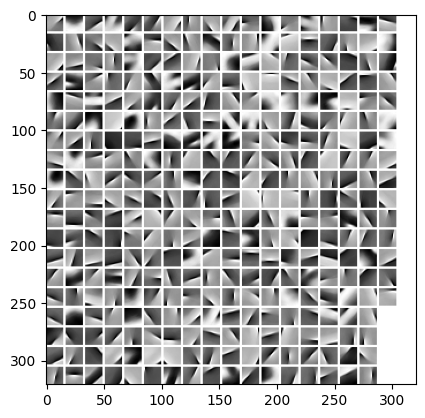

In [58]:
img_dict = get_dictionary_img(D)
plt.imshow(img_dict, cmap='gray')
plt.show()

## Confidence region estimation / density estimation

In [59]:
# PREPROCESSING: exclude black patches
v = np.median(V, axis=0)
V = V[:,v > 0.06]

In [60]:
# PREPROCESSING: remove the mean from each patch
V = V - np.mean(V, axis=0, keepdims=True)

In [61]:
# sparse coding of each patch in V
X = np.zeros((natom, npatch_region))
for i in range(V.shape[1]):
    x = fista(D, V[:, i], lmbda)
    X[:, i] = x



In [62]:
# computing the anomaly indicators (l1 norm, reconstruction error) for each
# patch in V

A = np.zeros((2, V.shape[1]))     # each column contains the values of the anomaly_scores for a patch

for i in range(V.shape[1]):
    recon = D @ X[:, i]
    error = np.linalg.norm(V[:, i] - recon)
    l1_norm = np.sum(np.abs(X[:, i]))
    A[:, i] = [l1_norm, error]

# Estimation of mean and covariance
mu = np.mean(A, axis=1)
Sigma = np.cov(A)


In [63]:
# estimation of the threshold that gives the desired false positive rate
# using the patches in V

FPR_target = 0.1

# compute the Mahalanobis distance for each indicator vector in A
mahal_dist = np.zeros(V.shape[1])
for i in range(A.shape[1]):
   mahal_dist[i] = (A[:, i] - mu).T @ np.linalg.inv(Sigma) @ (A[:, i] - mu)

# set the threshold
threshold = np.quantile(mahal_dist, 1 - FPR_target) 


## Test phase

In [64]:
# load the test image
img_test = imread(f'{rootfolder}/data/img_anom.png') / 255

imsz = img_test.shape

STEP = 7
# initialize the estimated image
heatmap = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

In [65]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        s = img_test[i : i + p, j : j + p].flatten()

        if np.median(s) <= 0.06:
            score = 0
        else:
            s_mean = np.mean(s)
            s = s - s_mean
            x = fista(D, s, lmbda)
            recon = D @ x
            error = np.linalg.norm(s - recon)
            l1_norm = np.sum(np.abs(x))
            a = np.array([l1_norm, error])
            score = (a - mu).T @ np.linalg.inv(Sigma) @ (a - mu)

        heatmap[i : i + p, j : j + p] += score
        weights[i : i + p, j : j + p] += 1

In [70]:
# normalize the heatmap
heatmap = heatmap / weights

/var/folders/tj/0mk4td753wdf74lwb26db8lc0000gn/T/ipykernel_31680/3950609915.py:2: RuntimeWarning: invalid value encountered in divide
  heatmap = heatmap / weights


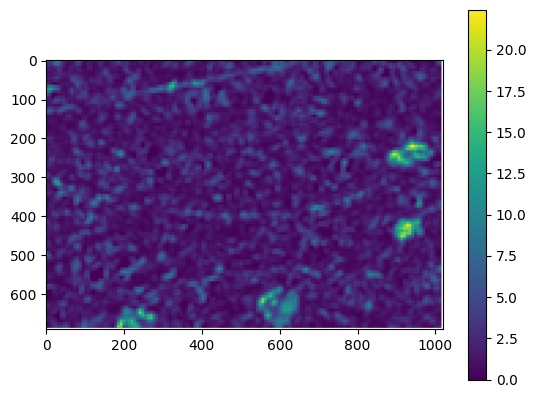

In [75]:
# plot the heatmap
plt.imshow(heatmap)
plt.colorbar()

In [82]:
# build the detection mask, that has the same size of the test image
# each pixel in the mask has value 1 if the corresponding patch has been
# detected as anomalous, otherwise it has value 0
mask = np.where(heatmap > 7.5, 1, 0)


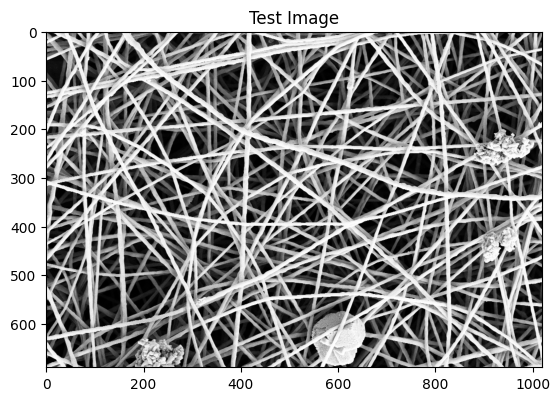

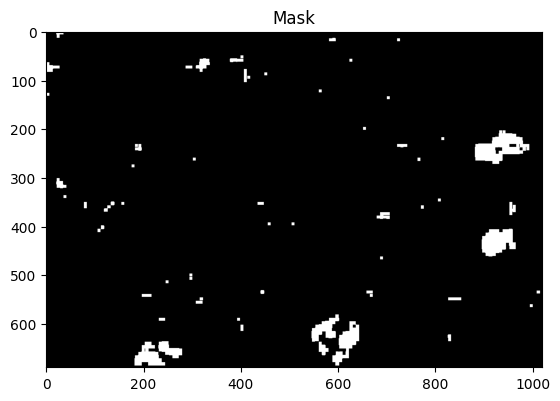

In [83]:
## show the results
plt.figure(3), plt.imshow(img_test, cmap='gray'), plt.title('Test Image')
plt.figure(4), plt.imshow(mask, cmap='gray'), plt.title('Mask')
plt.show()

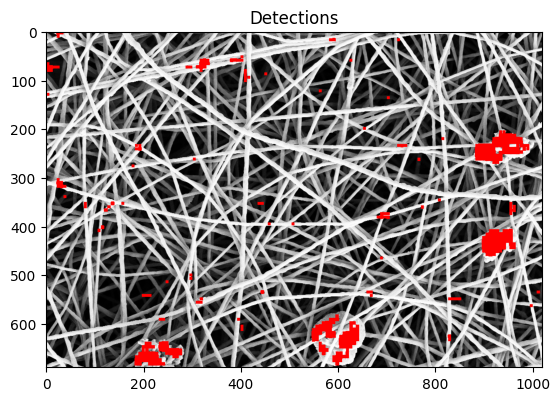

In [84]:
# combine the mask and the test image
img_color = np.zeros([img_test.shape[0], img_test.shape[1], 3])
img_temp = img_test.copy()
img_temp[mask > 0] = 1
img_color[:,:,0] = img_temp
img_temp = img_test.copy()
img_temp[mask > 0] = 0
img_color[:,:,1] = img_temp
img_temp = img_test.copy()
img_temp[mask > 0] = 0
img_color[:,:,2] = img_temp

plt.figure(5), plt.imshow(img_color), plt.title('Detections')
plt.show()